# Çoklu Çıktı Veren Model (Multi-Output)

Bir model aynı anda:
* BinaryClassification
* MulticlassClassification
* Regression

yapabilir mi?

**Mantık:** 3 farklı Dense layer kullanarak model yazmak.

## Kütüphaneler
* Data: https://www.kaggle.com/nipunarora8/age-gender-and-ethnicity-face-data-csv

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.metrics import mean_absolute_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

print('TF Version:' + tf.__version__)

1 Physical GPUs, 1 Logical GPUs
TF Version:2.7.0


## Veriye Göz Atış

In [2]:
df = pd.read_csv('age_gender.csv')
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


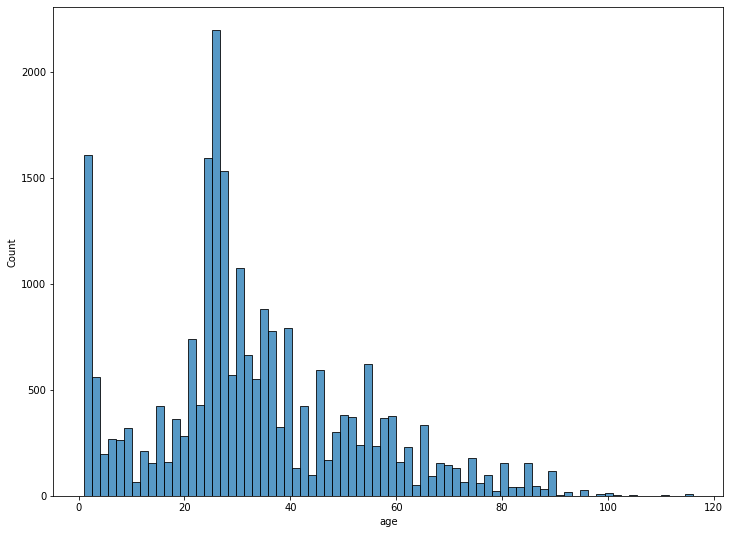

In [3]:
# Yaş
plt.figure(figsize = (12, 9))
sns.histplot(df['age']);

<AxesSubplot:xlabel='ethnicity', ylabel='count'>

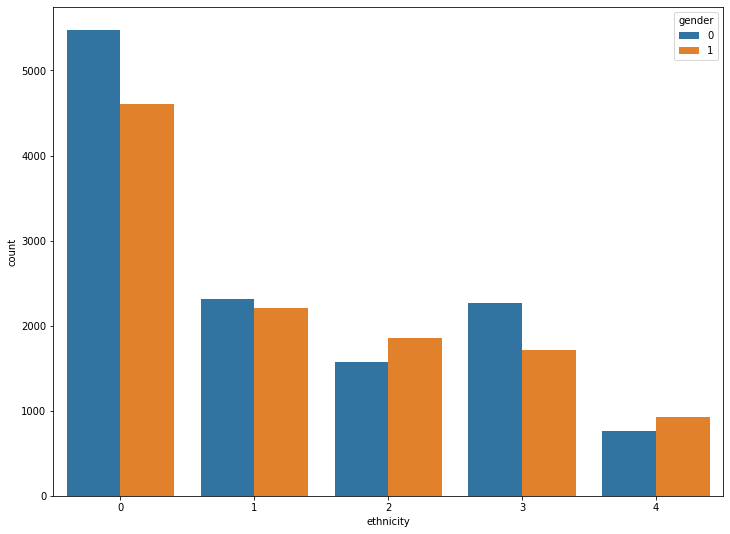

In [4]:
# Etnik
plt.figure(figsize = (12, 9))
sns.countplot(data = df, x = 'ethnicity', hue = 'gender')

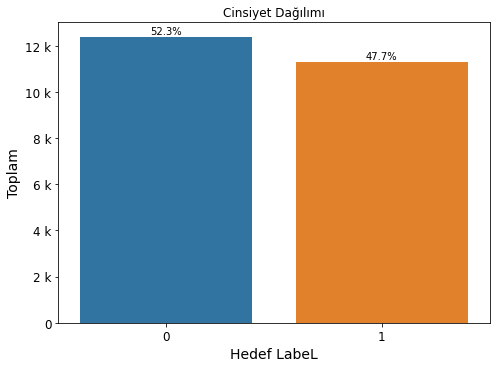

In [5]:
plt.figure(figsize = (7,5))
ax = sns.countplot(data = df, x = 'gender')
plt.xticks(size=12)
plt.xlabel('Hedef LabeL', size = 14)
plt.yticks(size=12)
plt.ylabel('Toplam', size=14)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

ax.set_xticklabels(ax.get_xticklabels(), ha="center")
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.title('Cinsiyet Dağılımı')
plt.show()

In [6]:
# csv'de pikseller string olarak verilmiş.
df['pixels'] = df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

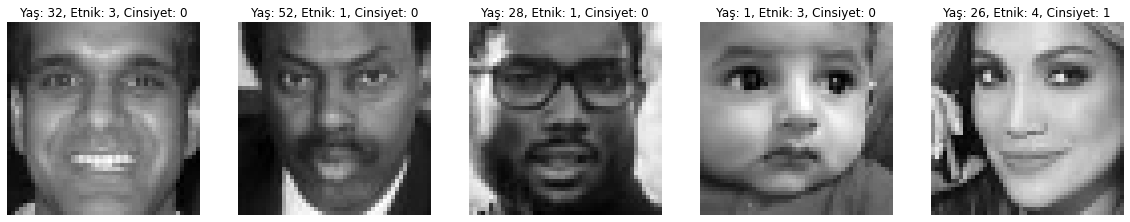

In [7]:
# Plot some pictures
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(df))
    
    age = df['age'][random_face]
    ethnicity = df['ethnicity'][random_face]
    gender = df['gender'][random_face]
    
    axes[i].set_title('Yaş: {0}, Etnik: {1}, Cinsiyet: {2}'.format(age, ethnicity, gender))
    axes[i].imshow(df['pixels'][random_face], cmap = plt.cm.gray)
    axes[i].axis('off')

## tf.data Pipeline Kurmak

In [8]:
# Set y
targets = df[['age', 'gender', 'ethnicity']].values
images = df['pixels'].values
images # Images gördüğünüz üzere array içinde arrayler içeriyor. TensorFlow bu şekilde çalışamaz.

array([array([[129., 128., 128., ..., 118.,  99.,  53.],
              [130., 129., 128., ..., 117.,  98.,  52.],
              [131., 129., 130., ..., 114.,  97.,  50.],
              ...,
              [121., 138., 147., ..., 151., 150., 148.],
              [117., 137., 146., ..., 149., 148., 148.],
              [115., 135., 142., ..., 146., 146., 146.]], dtype=float32),
       array([[164.,  74., 111., ..., 111., 111., 104.],
              [179.,  70., 128., ..., 112., 113., 108.],
              [176.,  71., 146., ..., 112., 112., 109.],
              ...,
              [192., 196., 235., ..., 111., 124., 112.],
              [230., 226., 233., ..., 198., 197., 180.],
              [238., 239., 233., ..., 182., 170., 148.]], dtype=float32),
       array([[ 67.,  70.,  71., ..., 197., 194., 192.],
              [ 65.,  66.,  69., ..., 197., 194., 192.],
              [ 61.,  63.,  69., ..., 197., 194., 190.],
              ...,
              [159., 157., 159., ..., 114., 105., 105.

In [9]:
images = np.array(images.tolist())
images # Arrayleri birleştirmiş olduk.

array([[[129., 128., 128., ..., 118.,  99.,  53.],
        [130., 129., 128., ..., 117.,  98.,  52.],
        [131., 129., 130., ..., 114.,  97.,  50.],
        ...,
        [121., 138., 147., ..., 151., 150., 148.],
        [117., 137., 146., ..., 149., 148., 148.],
        [115., 135., 142., ..., 146., 146., 146.]],

       [[164.,  74., 111., ..., 111., 111., 104.],
        [179.,  70., 128., ..., 112., 113., 108.],
        [176.,  71., 146., ..., 112., 112., 109.],
        ...,
        [192., 196., 235., ..., 111., 124., 112.],
        [230., 226., 233., ..., 198., 197., 180.],
        [238., 239., 233., ..., 182., 170., 148.]],

       [[ 67.,  70.,  71., ..., 197., 194., 192.],
        [ 65.,  66.,  69., ..., 197., 194., 192.],
        [ 61.,  63.,  69., ..., 197., 194., 190.],
        ...,
        [159., 157., 159., ..., 114., 105., 105.],
        [102., 114., 110., ..., 114., 110., 107.],
        [ 98.,  97.,  95., ..., 112., 111., 108.]],

       ...,

       [[ 59.,  50.,  37

In [10]:
# Train test split - tf.data take() ve skip() ile de yapılabilirdi.
# tf.data'dan önce train-test spliti yapıyoruz.

x_train, x_test, y_train, y_test = train_test_split(images, targets, test_size=0.2, random_state=42)

In [11]:
# Float32'ye cast ediyoruz.
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [12]:
# Scaler oluştur.
scaler = StandardScaler()

# Train datasetinde fit_transform
y_train[:, 0] = scaler.fit_transform(y_train[:, 0].reshape(-1, 1)).squeeze()

# Test datasında sadece TRANSFORM!!!
y_test[:, 0] = scaler.transform(y_test[:, 0].reshape(-1, 1)).squeeze()

In [ ]:
# train_ds = tf.data.Dataset.from_tensor_slices( (x_train, {y_train}) )

In [13]:
# tf.data kullanırken çoklu output vermek için bu şekilde dictionary verebiliriz.
# Çoklu input için de aynı mantık olacaktı, x_train yerine bir dict gelecekti.
train_ds = tf.data.Dataset.from_tensor_slices((x_train, 
                                               {'age' : y_train[:, 0],
                                                'gender': y_train[:, 1],
                                                'ethnicity': y_train[:, 2]}
                                              ))

test_ds = tf.data.Dataset.from_tensor_slices((x_test, 
                                              {'age' : y_test[:, 0],
                                               'gender': y_test[:, 1],
                                               'ethnicity': y_test[:, 2]}
                                             ))
# Elementlere baktığımızda dictionary görebiliyoruz.
print(train_ds.element_spec)

(TensorSpec(shape=(48, 48), dtype=tf.float32, name=None), {'age': TensorSpec(shape=(), dtype=tf.float32, name=None), 'gender': TensorSpec(shape=(), dtype=tf.float32, name=None), 'ethnicity': TensorSpec(shape=(), dtype=tf.float32, name=None)})


In [14]:
def prepare_dataset(features, targets):
    
    # Resimleri normalize et.
    features = features / 255.0
    
    # Channel dimension ekle.
    features = tf.expand_dims(features, axis = -1) # (48, 48) --> (48, 48, 1)
    
    # Transfer learning için RGB'ye dönüştür.
    features = tf.image.grayscale_to_rgb(features) # (48, 48, 1) --> (48, 48, 3) # tf.tile
    
    return features, targets

train_ds = train_ds.batch(128).map(prepare_dataset).shuffle(64).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(128).map(prepare_dataset).prefetch(tf.data.AUTOTUNE)

In [15]:
# Dataseti inceleyecek olursak:
# --> Her batchte 128 resim var. (128, 48, 48, 3)
# --> 128 tane age, ethnicity, gender var.
for x, y in train_ds.take(1):
    print(x.shape, y)

(128, 48, 48, 3) {'age': <tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.36554757,  0.33651277, -0.46584186, -0.11481173, -0.11481173,
       -0.36554757, -0.36554757,  2.843871  ,  2.0916636 , -0.3154004 ,
        1.7406334 ,  0.08577693, -1.6192268 , -1.2681966 ,  0.9382788 ,
        1.0385731 ,  1.590192  , -0.4156947 ,  0.83798444, -1.5690795 ,
       -1.418638  ,  0.2863656 , -0.46584186, -0.51598907, -0.4156947 ,
       -0.26525325,  0.03562977, -0.36554757, -0.11481173, -0.36554757,
       -1.0676079 ,  0.43680713, -1.2681966 ,  1.590192  , -0.36554757,
       -0.36554757, -0.51598907, -0.9673135 , -1.6192268 , -0.91716635,
       -1.6192268 , -0.1649589 ,  1.2391617 ,  2.0916636 ,  3.3453426 ,
       -0.26525325,  0.6373958 , -0.06466457,  0.1359241 , -0.8670192 ,
        2.0916636 ,  1.1388675 ,  0.08577693, -0.36554757, -0.66643053,
        0.83798444, -0.06466457,  0.18607126, -0.11481173,  0.53710145,
       -0.26525325, -0.46584186, -0.0145174 ,  2.593135  ,  0.3

In [16]:
# Açıklamalar
# weights = 'imagenet' = Modelin imagenet üzerinde eğitilmiş ağırlıklarını alıyoruz.
# include_top = False = Sondaki dense layerlarını modele dahil edelim mi? False --> Hayır
#                       Dahil olsaydı sonda 1000 unit içeren dense layer olacaktı. Çünkü
#                       imagenet verisinde 1000 sınıf vardır.
# input_shape = (48, 48, 3) = Bu modelde kullanılacak InputLayer'ın shape'i.

base_model = tf.keras.applications.DenseNet121(input_shape = (48, 48, 3),
                                              weights = 'imagenet',
                                              include_top = False)

In [17]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 24, 24, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1/conv[0][0]']             
                                                                                        

In [18]:
global_pool = GlobalMaxPooling2D()(base_model.output)

age_output = Dense(1, name = 'age')(global_pool)
ethnicity_output = Dense(5, activation = 'softmax', name = 'ethnicity')(global_pool)
gender_output = Dense(1, activation = 'sigmoid', name = 'gender')(global_pool)

model = tf.keras.Model(inputs = base_model.input, 
                       outputs = [age_output,
                                  ethnicity_output,
                                  gender_output])
model

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.785422 to fit



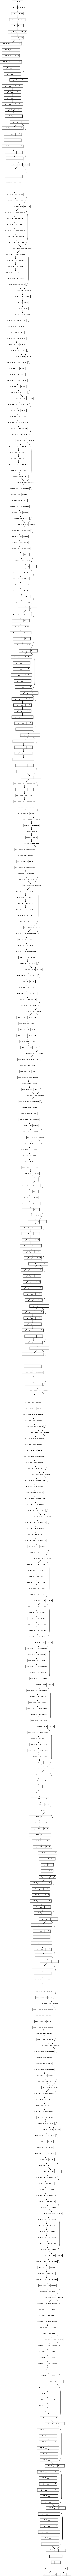

In [19]:
tf.keras.utils.plot_model(model, 'model.png')

In [20]:
# Callbacks
callbacks = [EarlyStopping(patience=5, monitor='val_loss', mode='min',
                           restore_best_weights = True),
             ReduceLROnPlateau(patience=2, verbose=1, monitor = 'val_loss',
                              factor = 0.01)]

In [21]:
# Layer isimlerine göre loss belirlendi.

model.compile(optimizer = Adam(),
              loss = {'age': tf.keras.losses.MeanSquaredError(), # Regression
                     'gender': tf.keras.losses.BinaryCrossentropy(), # BinaryClassification
                     'ethnicity': tf.keras.losses.SparseCategoricalCrossentropy()}) # MultiClass Classification

In [22]:
history = model.fit(train_ds, 
                        epochs=16,
                        callbacks=callbacks,
                        validation_data=test_ds) 

Epoch 1/16
149/149 [==============================] - 66s 259ms/step - loss: 2.1109 - age_loss: 0.5755 - ethnicity_loss: 1.0767 - gender_loss: 0.4586 - val_loss: 2.6836 - val_age_loss: 1.1456 - val_ethnicity_loss: 1.1626 - val_gender_loss: 0.3754 - lr: 0.0010
Epoch 2/16
149/149 [==============================] - 30s 203ms/step - loss: 1.2318 - age_loss: 0.2622 - ethnicity_loss: 0.6943 - gender_loss: 0.2752 - val_loss: 8.1578 - val_age_loss: 5.1184 - val_ethnicity_loss: 2.6412 - val_gender_loss: 0.3982 - lr: 0.0010
Epoch 3/16
149/149 [==============================] - 31s 207ms/step - loss: 1.0111 - age_loss: 0.2063 - ethnicity_loss: 0.5787 - gender_loss: 0.2260 - val_loss: 2.2664 - val_age_loss: 1.2493 - val_ethnicity_loss: 0.7043 - val_gender_loss: 0.3128 - lr: 0.0010
Epoch 4/16
149/149 [==============================] - 31s 207ms/step - loss: 0.8340 - age_loss: 0.1738 - ethnicity_loss: 0.4748 - gender_loss: 0.1854 - val_loss: 2.0050 - val_age_loss: 0.7430 - val_ethnicity_loss: 0.9888

## Classification Report Yazdırma

In [31]:
pred_age = []
pred_ethnicity = []
pred_gender = []

age = []
ethnicity = []
gender = []

for x, y in test_ds:
    predictions = model(x, training = False) # Sadece tahminleri aldığımız için training = False.
    # model(x) --> Direkt olarak __call__ metodunu çalıştırır.
    pred_age.append(predictions[0])
    pred_ethnicity.append(predictions[1])
    pred_gender.append(predictions[2])
    
    age.append(y['age'].numpy())
    ethnicity.append(y['ethnicity'].numpy())
    gender.append(y['gender'].numpy())

In [32]:
age = np.concatenate(age) # (128,) - (128, ) --> (256, ).. Batchleri concat. et.
ethnicity = np.concatenate(ethnicity)
gender = np.concatenate(gender)

pred_gender = np.concatenate(pred_gender)
pred_ethnicity = np.concatenate(pred_ethnicity)
pred_age = np.concatenate(pred_age)

In [33]:
pred_age = scaler.inverse_transform(pred_age)
mean_absolute_error(scaler.inverse_transform(age), pred_age)

5.9469733

In [34]:
pred_ethnicity = np.argmax(pred_ethnicity, axis = -1) # (0.1, 0.1, 0.1, 0.1, 0.6) --> 4 Argmax ile 4 sınıfını seçiyoruz.

print(classification_report(ethnicity, pred_ethnicity))

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85      2047
         1.0       0.86      0.87      0.86       904
         2.0       0.88      0.86      0.87       657
         3.0       0.76      0.76      0.76       804
         4.0       0.36      0.33      0.35       329

    accuracy                           0.81      4741
   macro avg       0.74      0.74      0.74      4741
weighted avg       0.81      0.81      0.81      4741



In [35]:
pred_gender = np.where(pred_gender > 0.5, 1, 0) # (0.78) --> Çıktı 0.5'ten büyükse 1.sınıf olarak kabul et.

print(classification_report(gender, pred_gender))

              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92      2468
         1.0       0.90      0.92      0.91      2273

    accuracy                           0.92      4741
   macro avg       0.92      0.92      0.92      4741
weighted avg       0.92      0.92      0.92      4741

